# ISE 6194 Final Project 
### Adelyn Arens and Amr Abu Orabi
### 04-28-23

### Load Packages

In [2]:
# Standard Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC

# Neural Network 
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# ignore the deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## ML Project 1: Used Car Auction Prices (Regression)

### Introduction/Motivation

The used car market is a multi-billion dollar industry, with an estimated value of over 180 billion dollars annually$_1$. With so much money at stake, it is critical for buyers, sellers, and dealers to have access to accurate and reliable information about the prices of used cars. The goal of this segment of our project is to apply machine learning algorithms to a large dataset that contains historical information about used cars and the price each car was sold for. By doing so, we hope to build models that predict the values of used cars with a high degree of accuracy. This enables buyers or sellers to estimate the price of a used car. We will utilize a dataset from Kaggle.com called the Used Car dataset$_4$. 

### Data Preprocessing and EDA

In [2]:
# Load the data
car_prices_full = pd.read_excel("car_prices.xlsx")
car_prices = car_prices_full.sample(frac=0.01, replace=True, random_state=1)
del car_prices_full # use this to delete the full dataset and free up memory
car_prices.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,year sold
128037,2007.0,BMW,5 Series,525xi,Sedan,automatic,wbanf33537cw70385,md,3.8,90993.0,black,gray,amber auto,8450.0,8000.0,Tue Jan 13 2015 09:30:00 GMT-0800 (PST),2015.0
491755,2013.0,Nissan,Versa,1.6 S Plus,sedan,NaN,3n1cn7ap4dl881526,ca,1.9,57220.0,red,black,the hertz corporation,8300.0,7000.0,Wed Jun 03 2015 05:30:00 GMT-0700 (PDT),2015.0
470924,2014.0,Chevrolet,Camaro,LS,coupe,manual,2g1fe1e39e9149985,az,4.4,15866.0,red,black,gm financial,18550.0,18200.0,Thu May 28 2015 05:00:00 GMT-0700 (PDT),2015.0


The dataset contains historical information about car auction sale prices.
The dataset includes:


*   Year: the year each car was manufactured.
*   Make: the brand of each car.
*   Model: the specific vehicle model.
*   Trim: the version of the vehicle's model.
*   Body: the body type of the car (SUV, Sedan, etc.) 
*   Transmission: whether the car is automatic or manual.
*   VIN: Vehicle Identification Number.
*   State: the state where each car was auctioned.
*   Condition: a rating out of 5 that reflects the car's condition.
*   Odometer: the mileage of each car sold.
*   Color:  color of each car.
*   Interior: interior color of each car.
*   Seller: the company or dealership that sold each car.
*   mmr: estimated selling price for each car by Manheim market record.
*   Sellingprice: the price for which each car was sold.
*   Saledate: the date on which each car was sold (month/date/year).
*   Year Sold: the year in which the car was sold (year only).

 Removing Irrelevant Variables:

* The VIN number is an identification number unique to each car. It does not have an impact on the car's price, so we believe it is reasonable to remove it.
* Since the body type of the car is correlated with car make and model, we believe it will not provide additional inforation. Thus, we will remove it.
* We will  remove the "mmr" variable since it is irrelevant for us.
* We will remove the 'saledate' variable since we only care about the year in which the car was sold.
* Even though information about the seller could be useful, we will remove the 'seller' variable for simplicity.

In [3]:
car_prices = car_prices.drop(["vin","body",'mmr','saledate','seller'] , axis=1)

Checking the data types of each variable:

In [4]:
print(car_prices.dtypes)

year            float64
make             object
model            object
trim             object
transmission     object
state            object
condition       float64
odometer        float64
color            object
interior         object
sellingprice    float64
year sold       float64
dtype: object


Converting the data types for 'sellingprice' and 'year sold' :

In [5]:
car_prices['sellingprice'] = car_prices['sellingprice'].astype(float)
car_prices['year sold'] = car_prices['year sold'].replace('#VALUE!', np.nan)
car_prices['year sold'] = car_prices['year sold'].astype(float)
print(car_prices.dtypes)

year            float64
make             object
model            object
trim             object
transmission     object
state            object
condition       float64
odometer        float64
color            object
interior         object
sellingprice    float64
year sold       float64
dtype: object


We will create a new variable called "age" which is equal to 'year sold' minus 'year'. This new variable will represent
how old the car was when it was sold. Then we will drop the 'year sold variable'.

In [6]:
car_prices['age'] = car_prices['year sold'] - car_prices['year']
car_prices = car_prices.drop(['year sold'],axis = 1)

In [7]:
print(car_prices['age'].value_counts())

 2.0     936
 3.0     885
 1.0     718
 4.0     472
 7.0     351
 8.0     279
 5.0     242
 9.0     238
 6.0     217
 10.0    188
 0.0     152
 11.0    137
 12.0    118
 13.0     79
 14.0     51
 15.0     35
 16.0     33
 17.0     21
 18.0     18
 20.0      8
 19.0      3
 25.0      2
 21.0      2
-1.0       2
 26.0      1
 22.0      1
Name: age, dtype: int64


We can see that some cars have an age of -1. This could be a typo where the year of the car or the saledate was entered wrong. However, we will remove these observations.

In [8]:
car_prices = car_prices.drop(car_prices[car_prices['age'] < 0].index)
print(car_prices['age'].value_counts())

2.0     936
3.0     885
1.0     718
4.0     472
7.0     351
8.0     279
5.0     242
9.0     238
6.0     217
10.0    188
0.0     152
11.0    137
12.0    118
13.0     79
14.0     51
15.0     35
16.0     33
17.0     21
18.0     18
20.0      8
19.0      3
25.0      2
21.0      2
26.0      1
22.0      1
Name: age, dtype: int64


**Cleaning the dataset:**

Checking for Missing Values:

In [9]:
print(car_prices.isnull().sum())

year            399
make            485
model           485
trim            490
transmission    997
state           399
condition       451
odometer        401
color           401
interior        401
sellingprice    399
age             399
dtype: int64


In [10]:
car_prices = car_prices.dropna()
car_prices.count()

year            4465
make            4465
model           4465
trim            4465
transmission    4465
state           4465
condition       4465
odometer        4465
color           4465
interior        4465
sellingprice    4465
age             4465
dtype: int64

Checking for duplicated observations(rows):

In [11]:
duplicates = car_prices.duplicated()
print("Number of duplicate observations:", duplicates.sum())

Number of duplicate observations: 18


In [12]:
# Remove duplicates
car_prices.drop_duplicates(keep='first', inplace=True)  # This removes all but one copy of the records 
car_prices = car_prices.reset_index(drop=True)

Creating dummy variables for categorical variables:

In [13]:
make_dummies = pd.get_dummies(car_prices['make'], prefix='make')   # creating dummies for make
car_prices = pd.concat([car_prices, make_dummies], axis=1)         #adding the dummy variable to the dataframe
car_prices = car_prices.drop(['make','make_Acura'], axis=1)         #removing the original "make" column and setting Acura as reference variable

model_dummies = pd.get_dummies(car_prices['model'], prefix='model') #repeating for model
car_prices = pd.concat([car_prices, model_dummies], axis=1)         
car_prices = car_prices.drop(['model','model_ILX'], axis=1)

trim_dummies = pd.get_dummies(car_prices['trim'], prefix='trim')   #repeating for trim
car_prices = pd.concat([car_prices, trim_dummies], axis=1)   
car_prices = car_prices.drop(['trim','trim_Technology Package'], axis=1)

color_dummies = pd.get_dummies(car_prices['color'], prefix='color')   #repeating for color
car_prices = pd.concat([car_prices, color_dummies], axis=1)  
car_prices = car_prices.drop(['color','color_black'], axis=1)

interior_dummies = pd.get_dummies(car_prices['interior'], prefix='interior')   #repeating for interior
car_prices = pd.concat([car_prices, interior_dummies], axis=1)   
car_prices = car_prices.drop(['interior','interior_black'], axis=1)

transmission_dummies = pd.get_dummies(car_prices['transmission'], prefix='transmission') #repeating for transmission
car_prices = pd.concat([car_prices, transmission_dummies], axis=1)         
car_prices = car_prices.drop(['transmission','transmission_automatic'], axis=1)

state_dummies = pd.get_dummies(car_prices['state'], prefix='state') #repeating for state
car_prices = pd.concat([car_prices, state_dummies], axis=1)         
car_prices = car_prices.drop(['state','state_ca'], axis=1)

car_prices.head(3)   #checking the dataframe

,year,condition,odometer,sellingprice,age,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,...,state_or,state_pa,state_pr,state_sc,state_tn,state_tx,state_ut,state_va,state_wa,state_wi
0,2007.0,3.8,90993.0,8000.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014.0,4.4,15866.0,18200.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015.0,3.7,7010.0,21495.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checking for outliers:

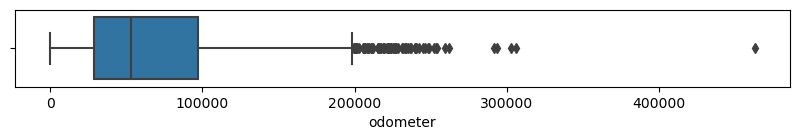

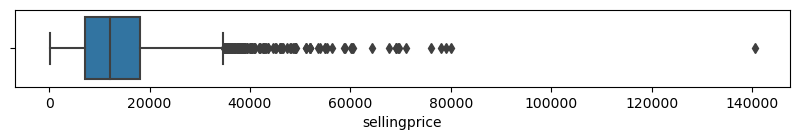

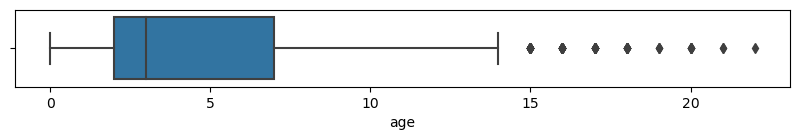

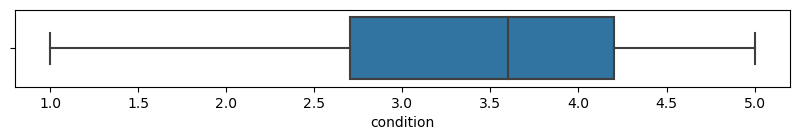

In [14]:
numeric_vars = ['odometer','sellingprice','age','condition'];

for att in numeric_vars:
    plt.figure(figsize=(10,1))
    sns.boxplot(x=att, data=car_prices)
    plt.show()

Regarding the outliers for the odometer variable, we will keep them because this just means that some cars have travelled for long distances. It is not an error. Moreover, we will keep the outliers for the selling price variable. These high prices correspond to car models that are expensive. Thus, we will keep them.

Checking correlation between numerical variables:

<AxesSubplot:>

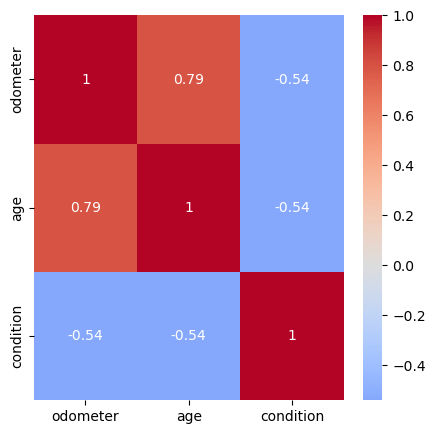

In [15]:
numeric_vars = ['odometer','age','condition'];   #removed sellingprice from numeric_vars

cor = car_prices[numeric_vars].corr(method='pearson').round(2)
plt.figure(figsize=(5,5))
sns.heatmap(cor,annot=True, center=0.0, cmap='coolwarm')

We can see that the numerical variables are highly correlated, especially odometer and age. We will keep these variables, even though one of them should be removed, to observe how the different regression models handle multicollinearity.

### Model Preparation

In [16]:
# Split into features and response
X = car_prices.drop(columns=['sellingprice'])
y = car_prices['sellingprice']

# Standardize columns 
sc_x = StandardScaler() #instanciate the class
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.33, random_state = 27)

In [17]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.0001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])  #As a convention, we append an underscore (_) to attributes that are not being created
                                                #upon the initialization of the object but by calling the object's other methods.
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

### Regression Models

**Linear Regression GD**

In [18]:
lr = LinearRegressionGD() #instaniate the class
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test) # predict test values
test_mse = round(mean_squared_error(y_test, lr_prediction),2) # calculate test mse

The Test MSE of the Linear Regression with Gradient Descent: 0.17


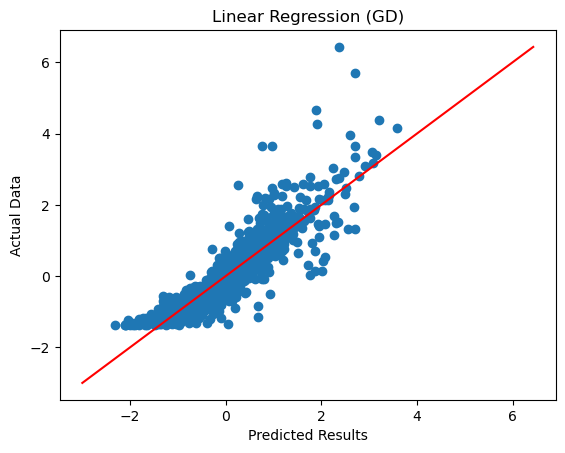

In [20]:
plt.scatter(lr_prediction,y_test)
plt.xlabel('Predicted Results')
plt.plot(np.linspace(-3, np.max(y_test)), np.linspace(-3, np.max(y_test)), 'r') # Add red y=x line
plt.ylabel('Actual Data')
plt.title("Linear Regression (GD)")

print("The Test MSE of the Linear Regression with Gradient Descent: {}".format(test_mse))

**Analysis:** 

The model performs very well. The plot indicates that the predicted results are accurate since the points are clustered closely around the y=x line. Moreover, the test MSE is small.

**Ridge Regression**

The optimal shrinkage parameter: 10
The Test MSE of the Ridge Regression: 0.18


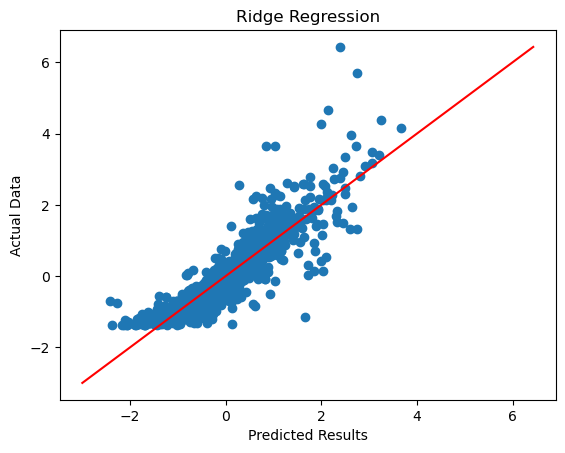

In [22]:
parameters = {'alpha':[1, 10]}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

#fit the grid search
Ridge_reg.fit(X_train,y_train)

# best estimator
best_estimator = Ridge_reg.best_estimator_
# Extract the shrinkage penalty (alpha) from the best estimator
shrinkage_penalty = best_estimator.alpha

# best model
best_model = Ridge_reg.best_estimator_
best_model.fit(X_train,y_train)
ridge_prediction = best_model.predict(X_test)
test_mse = round(mean_squared_error(y_test, ridge_prediction),2)

# Plot 
plt.scatter(ridge_prediction,y_test)
plt.plot(np.linspace(-3, np.max(y_test)), np.linspace(-3, np.max(y_test)), 'r') # Add red y=x line
plt.xlabel('Predicted Results')
plt.ylabel('Actual Data')
plt.title("Ridge Regression")

print("The optimal shrinkage parameter: {}".format(round(shrinkage_penalty,2)))
print("The Test MSE of the Ridge Regression: {}".format(test_mse))

**Analysis:** 

A much bettter performing model for the data. The test MSE is 0.18. Moreover, the points are scattered closely about the y=x line. This means that the predicted results are close to the actual data.

**Lasso Regression**

The optimal shrinkage parameter: 1
The Test MSE of the LASSO Regression: 0.91


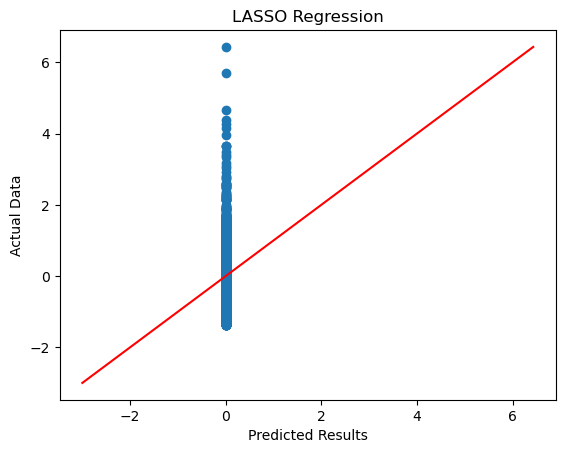

In [23]:
parameters = {'alpha':[1, 10]}

# define the model/ estimator
model = Lasso()

# define the grid search
Lasso_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

#fit the grid search
Lasso_reg.fit(X_train,y_train)

# best estimator
best_estimator = Lasso_reg.best_estimator_

# Extract the shrinkage penalty (alpha) from the best estimator
shrinkage_penalty = best_estimator.alpha

# best model
best_model = Lasso_reg.best_estimator_
best_model.fit(X_train,y_train)
Lasso_prediction = best_model.predict(X_test)
test_mse = round(mean_squared_error(y_test, Lasso_prediction),2)

# Plot
# Plot 
plt.scatter(Lasso_prediction,y_test)
plt.plot(np.linspace(-3, np.max(y_test)), np.linspace(-3, np.max(y_test)), 'r') # Add red y=x line
plt.xlabel('Predicted Results')
plt.ylabel('Actual Data')
plt.title("LASSO Regression")


# LASSO
print("The optimal shrinkage parameter: {}".format(round(shrinkage_penalty,2)))
print("The Test MSE of the LASSO Regression: {}".format(test_mse))

**Analysis:**

Even though the test MSE is relatively small, we can see from the plot that the predicted results are not close to the actual data. Thus, we conclude that this model performs poorly.

**Elastic Net**

The optimal shrinkage parameter: 1
The Test MSE of the Elastic Net Regression: 0.82


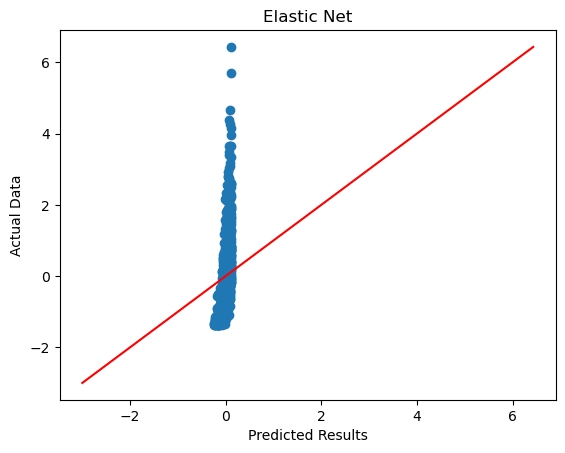

In [24]:
parameters = {'alpha':[1, 10]}

# define the model/ estimator
model = ElasticNet()

# define the grid search
EN_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

#fit the grid search
EN_reg.fit(X_train,y_train)

# best estimator
best_estimator = EN_reg.best_estimator_

# Extract the shrinkage penalty (alpha) from the best estimator
shrinkage_penalty = best_estimator.alpha

# best model
best_model = EN_reg.best_estimator_
best_model.fit(X_train,y_train)
EN_prediction = best_model.predict(X_test)
test_mse = round(mean_squared_error(y_test, EN_prediction),2)

# Plot
# Plot 
plt.scatter(EN_prediction,y_test)
plt.plot(np.linspace(-3, np.max(y_test)), np.linspace(-3, np.max(y_test)), 'r') # Add red y=x line
plt.xlabel('Predicted Results')
plt.ylabel('Actual Data')
plt.title("Elastic Net")
print("The optimal shrinkage parameter: {}".format(round(shrinkage_penalty,2)))
print("The Test MSE of the Elastic Net Regression: {}".format(test_mse))

**Analysis:**

Similar to the LASSO regression model, the test MSE is small but the plot indicates that the model does not perform well since the points do not lie closely to the y=x plot.

**Neural Network: 1 Linear Layer**

Due to the large dimensions of the dataset, it will be very difficult to create a Neural Network. 

In [25]:
# Convert the normalized data to a PyTorch tensor
X_train_norm_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# make X_test and y_test tensors
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create a TensorDataset
train_ds = TensorDataset(X_train_norm_tensor, y_train_tensor)

# Create a PyTorch DataLoader
train_dl = DataLoader(train_ds, batch_size = 10, shuffle=True)

In [26]:
"""
Function to learn the parameters for a neural network model while recording the loss history for
both train and test sets. 
"""
def train(model, num_epochs, train_dl, X_test, y_test, n_train, batch_size):
    loss_hist_train = [0] * num_epochs # keep track of train MSE
    loss_hist_test = [0] * num_epochs # keep track of test MSE
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0] # predict with current weights
            loss = loss_fn(pred, y_batch) # calculate loss
            loss.backward() # calculate gradient
            optimizer.step() # update parameters
            optimizer.zero_grad() # reset gradient to 0 to save memory
            loss_hist_train[epoch] += loss.item() # add each mini-batch loss to total loss for epoch

        loss_hist_train[epoch] /= n_train/batch_size # normalize loss for epoch

        pred = model(X_test)[:, 0] # predict values with current weights on test set
        loss = loss_fn(pred, y_test) # calculate test MSE for epoch
        loss_hist_test[epoch] = loss.item() # record test loss for epoch 
        
    return loss_hist_train, loss_hist_test

In [27]:
"""
Function to plot the loss curves for the train and test set. 
"""
def plot_loss(history):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(history[0], lw=4)
    plt.plot(history[1], lw=4)
    plt.legend(['Train loss', 'Test loss'], fontsize=12)
    ax.set_xlabel('Epochs', size=15)

In [28]:
torch.manual_seed(1) # set seed for reproducibility
num_epochs = 200
batch_size = 10
n_train = len(X_train)

In [29]:
model = nn.Linear(X_train.shape[1],1) # initialize a model with 10 input features and 1 output
loss_fn = nn.MSELoss(reduction='mean') # use MSE loss function 
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001) # use to update model parameters with SGD

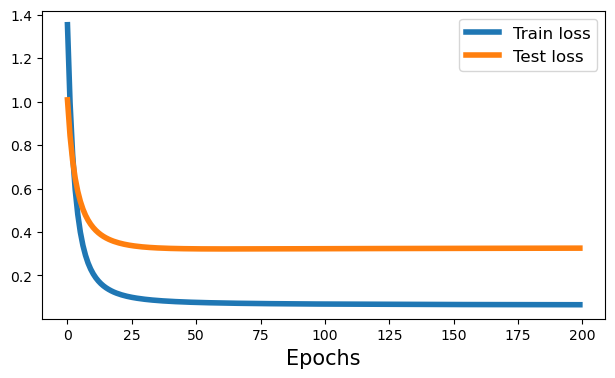

In [30]:
history = train(model, num_epochs, train_dl, X_test_tensor, y_test_tensor, n_train, batch_size)
plot_loss(history)

In [31]:
print("The lowest test MSE achieved with the Neural Network: {}".format(round(min(history[1]),2)))

The lowest test MSE achieved with the Neural Network: 0.32


**Analysis:** While this dataset is difficult with a neural network due to its large dimensions, it was one of the better models trained. The Test MSE is much lower than that of the LASSO regression, Elastic Net Regression, and Linear Regression model (Sickit Learn).

### Summary of Results/Conclusions 



| Model     | MSE |
| ----------- | ----------- |
| Linear Regression GD    | 0.17       |
| Ridge Regression  | 0.18     |
| LASSO Regression  | 0.91        |
| Elastic Net Regression | 0.82       |
| Neural Network  | 0.32      |

The best performing models for our data are the linear regression(GD) and the ridge regression models. They both gave us small test MSE values and the plots show that the predicted results are accurate and close to the actual data. The rest of the models performed very badly. The linear regression(Sickit Learn) model resulted in a huge test MSE. The LASSO and elastic net models gave small test MSEs but the plots indicated that the predicted results are inaccurate. To conclude, the best models to use for this type of data are linear regression(GD) and ridge regression.

# ML Project 2: Start-up Success (Classification)

### Introduction/Motivation

A start-up business can be viewed as risky for both entrepreneurs and investors. However, starting and investing in startups is a common practice in the United States. In 2022, 240 billion dollars of venture capital funds were invested into startup companies, but only about 10% of startups go on to be successful$_2$.

This gap is important to understand for both entreprenuers who may be looking to start their own company or investors looking to supply venture capital funds. In this project, we will develop a model to predict if a startup is likely to succeed in order to help guide stakeholders to smart investments. We will utilize a dataset from Kaggle.com called the Startup Success Prediction dataset$_3$. 

### Data Preprocessing and Preliminary EDA

This dataset has a usability score of 5.88/10. This means we will have to do some data preprocessing. 

**Removing Variables**

In [3]:
# Loading Data
startup = pd.read_csv('startup data.csv')

In [4]:
# Removing irrelavent variables, unique identifiers, and categorical fields where each value has a small sample size (ex: city)
startup = startup.drop(['Unnamed: 0','latitude', 'longitude', 'zip_code', 'city', 'id', 
                        'Unnamed: 6', 'name', 'object_id', 'labels'], axis=1)

In [5]:
"""
The date of the company being founded and the date the company recieved their first funding are not useful on their own,
but the distance between these dates (time to first funding) could be useful. However, this information is already captured
in other variables, so we can just remove them from the dataset. 
"""
# Drop first_funding_at and founded_at variables 
startup = startup.drop(['founded_at', 'first_funding_at'], axis=1)

In [6]:
"""
Some variables provide useful information, but it is information that we would not know when looking to predict
new cases, so we must remove these variables. Some examples of this include, date of last funding, closing date, and age
at last milestone.
"""
# Drop variables 
startup = startup.drop(['closed_at', 'last_funding_at', 'age_last_funding_year','age_last_milestone_year'], axis=1)

**Categorical Variables**

In [7]:
"""
The majority of the start-ups (over 80%) are located in California, New York, Texas, and Massachusetts. 
Each additional state has a very small sample size, so we think it would be best to use the provided state indicator
variables for CA, NY, TX, MA, and Other and drop the two state_code fields (We think the second state_code field 
is a duplicate field)
"""
# Drop variables
startup = startup.drop(['state_code', 'state_code.1'], axis=1)

In [8]:
# Reviewing the "Company Type" fields 
company_types = startup[["is_software", "is_web", "is_mobile", "is_enterprise", "is_advertising", "is_gamesvideo", "is_ecommerce", 
                         "is_biotech", "is_consulting", "is_othercategory"]]

# Checking how many companies are of each type 
print(company_types.mean()*923)

# Since there are only 3 consulting, adding those to is_othercategory
for i in range(len(startup)):
    if startup['is_consulting'][i] == 1:
        startup['is_othercategory'][i] ==1

# drop is_consulting and also category_code because it is repetitive also drop is_othercategory so we have a reference category
startup = startup.drop(['is_consulting', 'category_code', 'is_othercategory'], axis=1)

is_software         153.0
is_web              144.0
is_mobile            79.0
is_enterprise        73.0
is_advertising       62.0
is_gamesvideo        52.0
is_ecommerce         25.0
is_biotech           34.0
is_consulting         3.0
is_othercategory    298.0
dtype: float64


In [9]:
"""
All of the remaining categorical variables seem to have a reasonable sample size. 
"""

categorical_vars = ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB',
                         'has_roundC', 'has_roundD', 'is_top500', 'status']

print(startup[categorical_vars].mean()*923)

is_CA            487.0
is_NY            106.0
is_MA             83.0
is_TX             42.0
is_otherstate    204.0
has_VC           301.0
has_angel        235.0
has_roundA       469.0
has_roundB       362.0
has_roundC       215.0
has_roundD        92.0
is_top500        747.0
dtype: float64


In [10]:
# Drop is_otherstate to set reference category 
startup = startup.drop(['is_otherstate'], axis=1)

**Numeric Variables**

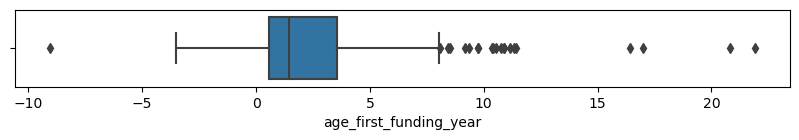

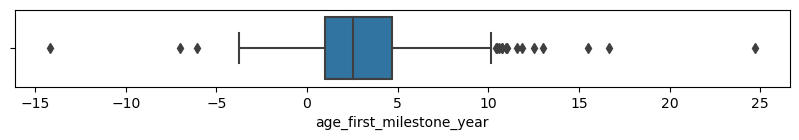

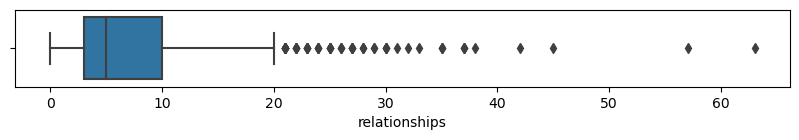

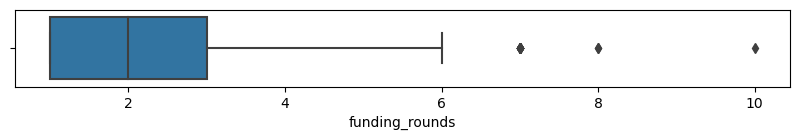

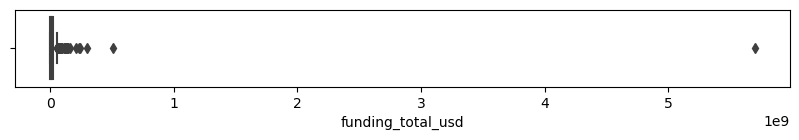

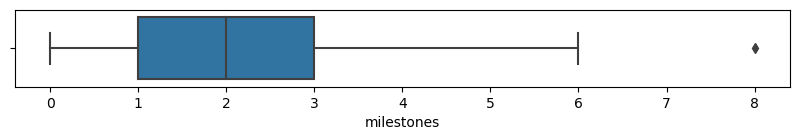

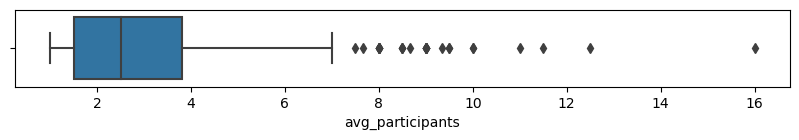

In [11]:
"""
Checking for outliers in the data. Since we have limited data, we will only remove the most extreme points

From the plots below the most problematic data may include: 
- The very large funding total
- Having 8 milestones 
- Average participants = 16

We will remove the data points with the problems described above. There is some concern about how it is possible to recieve funding or reach milestones
prior to being founded (negative numbers), but since there are so many data points that are negative, we assume that this is possible and correct data. 
"""
numeric_vars = ['age_first_funding_year', 'age_first_milestone_year', 'relationships', 'funding_rounds', 
                'funding_total_usd', 'milestones', 'avg_participants']

# Create a boxplot for each numeric variable
for att in numeric_vars:
    plt.figure(figsize=(10,1))
    sns.boxplot(x=att, data=startup)
    plt.show()

In [12]:
"""
These transformations will cut the dataset down from 923 records to 919 
"""

# funding_total_usd
startup = startup.loc[startup['funding_total_usd'] <= 500000000]

# milestones
startup = startup.loc[startup['milestones'] < 8]

# avg_participants
startup = startup.loc[startup['avg_participants'] < 14]

# Check that numeric variables are within normal range
startup[numeric_vars].describe() # looks good

,age_first_funding_year,age_first_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,avg_participants
count,919.000000,767.000000,919.000000,919.000000,9.190000e+02,919.000000,919.000000
mean,2.234497,3.051898,7.643090,2.309032,1.872253e+07,1.832427,2.821108
std,2.513615,2.981003,7.085452,1.391006,2.718374e+07,1.308675,1.826062
min,-9.046600,-14.169900,0.000000,1.000000,1.100000e+04,0.000000,1.000000
25%,0.569850,1.000000,3.000000,1.000000,2.725000e+06,1.000000,1.500000
50%,1.446600,2.517800,5.000000,2.000000,1.000000e+07,2.000000,2.500000
75%,3.575350,4.675350,10.000000,3.000000,2.450527e+07,3.000000,3.708350
max,21.895900,24.684900,63.000000,10.000000,2.995000e+08,6.000000,12.500000


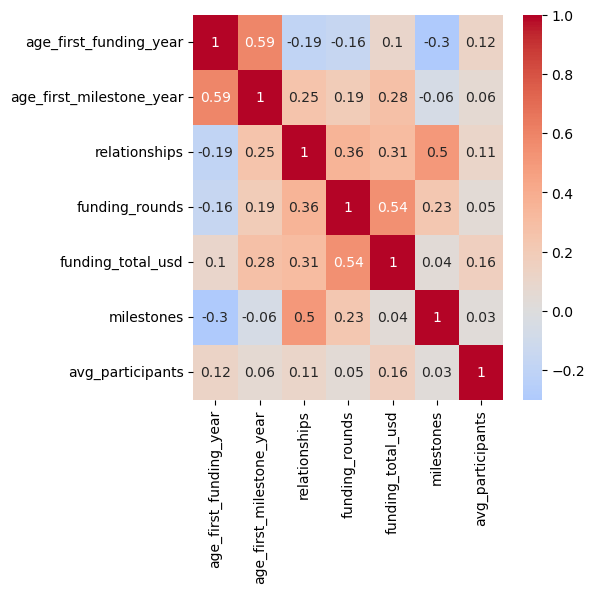

In [13]:
"""
Checking for correlation between the predictors. 

There is a lot of correlation between:
- 'age_first_funding_year' and 'age_first_milestone_year' 
  Solution: We will keep just age_first_funding_year
- 'funding_total_usd and 'funding_rounds' 
  Solution: We will just keep funding_total since the rounds can largely be derived from other variables 
"""

# Correlation matrix
cor = startup[numeric_vars].corr(method='pearson').round(2)
plt.figure(figsize=(5,5))
sns.heatmap(cor,annot=True, center=0.0, cmap='coolwarm')

# Drop correlated variables 
startup = startup.drop(['age_first_milestone_year', 'funding_rounds'], axis=1)

**Class Variable**

In [14]:
"""
We are checking how many startups closed vs got acquired 

The output shows that there is a good amount of both classes in this dataset and there are no missing values of 
the class variable. 
""" 

print(startup['status'].value_counts())

# Change acquired to 1 and closed to 0
startup.status.replace('acquired', 1, inplace=True)
startup.status.replace('closed', 0, inplace=True)

acquired    594
closed      325
Name: status, dtype: int64


The final cleaned dataset has 919 records with 25 features. 

### **Final Variables Description**
1. **age_first_funding_year**: number of years from foundation year when first funding is recieved (numerical, discrete). 
2. **relationships:** Number of relationships with investors, accountants, vendors, and mentors a startup has (numerical, discrete)
3. **funding_total_usd**: amount of funding recieved through all funding rounds (numerical, continuous)
4. **milestones:** Number of milestones reached by a startup (numerical, continuous). 
5. **is_CA:** indicator for if startup is located in California (1) or not (0) (categorical). 
6. **is_NY:** indicator for if startup is located in New York (1) or not (0) (categorical). 
7. **is_MA:** indicator for if startup is located in Massacheusetts (1) or not (0) (categorical). 
8. **is_TX:** indicator for if startup is located in Texas (1) or not (0) (categorical). 
9. **is_software:** indicator for if startup is a software company (1) or not (0) (categorical). 
10. **is_web:** indicator for if startup is a web development company (1) or not (0) (categorical). 
11. **is_mobile**: indicator for if startup is a mobile company (1) or not (0) (categorical). 
12. **is_enterprise**: indicator for if startup is an enterprise company (1) or not (0) (categorical). 
13. **is_advertising:** indicator for if startup is an advertising company (1) or not (0) (categorical).
14. **is_gamesvideo:** indicator for if startup is an video or gaming company (1) or not (0) (categorical).
15. **is_ecommerce:**indicator for if startup is an ecommerce company (1) or not (0) (categorical).
16. **is_biotech:** indicator for if startup is a biotech company (1) or not (0) (categorical).
17. **has_VC:** indicator for if a startup has venture capital financing (1) or not (0) (categorical). 
18. **has_angel:** indicator for if a startup has an angel investor (1) or not (0) (categorical). 
19. **has_roundA:** indicator for if a startup has recieved round A funding (1) or not (0), which typically generates 2-15 million dollars (categorical). 
20. **has_roundB**: indicator for if a startup has recieved round B funding (1) or not (0), which typically generates 30-60 million dollars (categorical).  
21. **has_roundC:** indicator for if a startup has recieved round C funding (1) or not (0), which is given to well estabilished businesses (categorical). 
22. **has_roundD:** indicator for if a startup has recieved round D funding (1) or not (0), which is given to well established businesses (categorical). 
23. **avg_participants:** average number of relationships over the lifetime of the startup (numerical, discrete). 
24. **is_top500**: startup is accepted into global 500 which included venture capital firms with more than 2.7 billion in assets and is technologically focused (1), or not (0) (categorical). 
25. **status:** class variable (closed/acquired)

### Model Preparation

In [15]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    startup.iloc[:, 0:-1], startup.iloc[:, -1], test_size=0.33, random_state = 27)

# Standardize numeric predictors
numeric_clean_vars = ['age_first_funding_year', 'relationships', 'funding_total_usd', 
                    'milestones', 'avg_participants']
sc_x = StandardScaler()
X_train[numeric_clean_vars] = sc_x.fit_transform(X_train[numeric_clean_vars])
X_test[numeric_clean_vars] = sc_x.fit_transform(X_test[numeric_clean_vars])

### Helper Functions

**Confusion Matrix**

In [16]:
"""
This function will take the predicted and actual class values for the test data and display a confusion matrix. Additionally, 
this function displays some metrics related to the output such as accuracy and the false positive and negative rates. 
"""
def confusion_matrix_display(y_test, y_pred):
    # Print accuracy
    accuracy_lrgd = accuracy_score(y_test, y_pred)
    print(f"The accuracy of the model is: {accuracy_lrgd*100:.2f} %") 

    conf_matrix = confusion_matrix(y_test, y_pred) # generating confusion matrix
    # displaying confusion matrix
    plt.figure(figsize=(15,10))
    matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)  # Display confusion matrix
    matrix_display.plot()

**Plot Parameters**

In [17]:
"""
This function will generate a plot for each of the model parameters for SVM and Logistic Regression classifiers. 
After plotting the parameters, this function will return a list with the optimal parameters. 
"""

def plot_params(grid_results, plots):
    
    # initializing a list to hold the optimal model parameters
    optimal_params = []
    print("The maximum mean test score = {}".format(round(max(grid_results["mean_test_score"]), 3)))
    
    for param in plots: 
        # finding and appending optimal model parameters
        optimal_param = grid_results[param][grid_results["mean_test_score"].idxmax()]
        optimal_params.append(optimal_param)
        
        # grouping by the parameter being plotted to get an average at each value 
        model_results_grouped = grid_results.groupby(param).mean()
        values = model_results_grouped.index.tolist()
        mean_test = model_results_grouped["mean_test_score"].tolist()
        
        # plot the regularization parameters tried vs their mean cross validation score 
        plt.figure(figsize=(8,4))
        plt.plot(values, mean_test) # Plot
        plt.axvline(x=optimal_param, color="red") # line for the optimal parameter
        
        plt.xlabel("Parameter Value")
        plt.ylabel("Mean Accuracy at Parameter Value") 
        plt.title("Plot for '{}'".format(param))

        print("The optimal value for parameter '{}' = {}".format(param, round(optimal_param,4)))
    return(optimal_params)

**Grid Search**

In [18]:
"""
This function will preform the grid search for the optimal model parameters. It does not identify the optimal parameter, but rather returns the 
cross-validation score at each parameter value. 
"""

def grid_search(model, parameters, X_train, y_train):

    # instantiate grid search 
    grid_search = GridSearchCV(estimator = model,  
                           param_grid = parameters, 
                           scoring = 'accuracy',
                           cv = 5)

    # fit data to grid search
    grid_search.fit(X_train, y_train)  

    # putting the results of the grid search in a data frame
    grid_results = pd.DataFrame(grid_search.cv_results_)
    
    # return the data frame with the results 
    return(grid_results)

**Model Parameters**

In [19]:
"""
Setting model parameters 
For each SVM model, I will sample from these parameters depending on which need to be optimized for the given model 
"""
parameters = {'C':[0.001,0.01, 0.1,0.2,0.3,0.5,1,2,3,5,7,8,10,12,15],
              'degree': [1,2,3,4,5],
              'gamma':[0.001, 0.01, 0.1,0.2,0.3,0.5,0.6,0.7,0.7,0.9, 1]
              }

**Logistic Regression GD**

In [20]:
class LogisticRegressionGD(object):

    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
    Learning rate (between 0.0 and 1.0)
    n_iter : int   Passes over the training dataset.
    random_state : int    Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array    Weights after fitting.
    cost_ : list    Sum-of-squares cost function value in each epoch.

    """

    

    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of
        samples and
        n_features is the number of features.
        y : array-like, shape = [n_samples]
        Target values.
        Returns
        -------
        self : object
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=1 + X.shape[1])
        self.cost_ = []
        epsilon = 1e-5

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) -
                    ((1 - y).dot(np.log(1 - output+epsilon))))
            self.cost_.append(cost)

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X))
        # >= 0.5, 1, 0)

### Classification Models

**Logistic Regression (GD)**

The accuracy of the model is: 74.67 %


<Figure size 1500x1000 with 0 Axes>

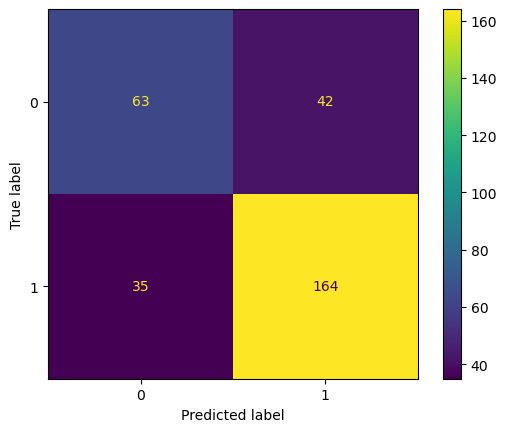

In [21]:
# instantiating class
lrgd = LogisticRegressionGD(eta=0.001,n_iter=1000,random_state=1) 

# fitting model
lrgd.fit(X_train,y_train)

# predicting on test data
log_pred = lrgd.predict(X_test) 

# Since the model has more than 2 dimensions, a confusion matrix can best display the model performance
confusion_matrix_display(y_test, log_pred)

**Analysis:**
The logistic regression with gradient descent was able to correctly classify 74.67% of the data points. The model predicted more false positives (startups being acquired when they actually failed) than false negatives (startups failing when they actually were acquired). This is not ideal as investors would probably feel more comfortable with a model that had less false positives. 

**Logistic Regression (Scikit Learn)**

The maximum mean test score = 0.741
The optimal value for parameter 'param_C' = 0.1


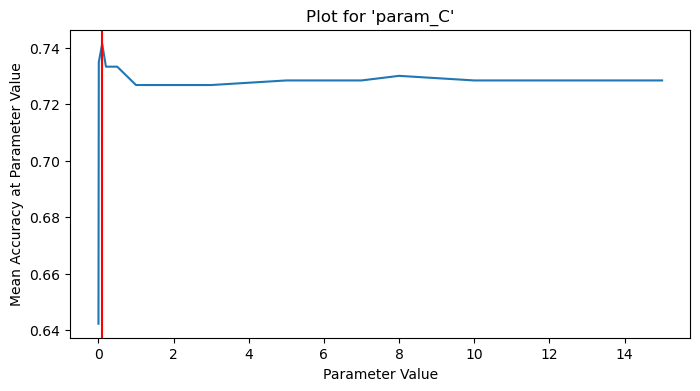

In [22]:
"""
Finding optimal model parameters using grid search and cross-validation. 
"""
# instantiate an instance of a logistic regression 
logreg = LogisticRegression(penalty = 'l2', max_iter=1000)

# Select the parameters to optimize 
parameters_log = dict((k, parameters[k]) for k in ('C')) # Only C for logistic regression

# perform the grid search for logistic regression
grid_results_log = grid_search(logreg, parameters_log, X_train, y_train)

# plot the results 
plots = ["param_C"]
optimal_params = plot_params(grid_results_log, plots)

The optimal shrinkage penalty for the scikit learn logistic regression is C = 0.1. 

The accuracy of the model is: 77.63 %


<Figure size 1500x1000 with 0 Axes>

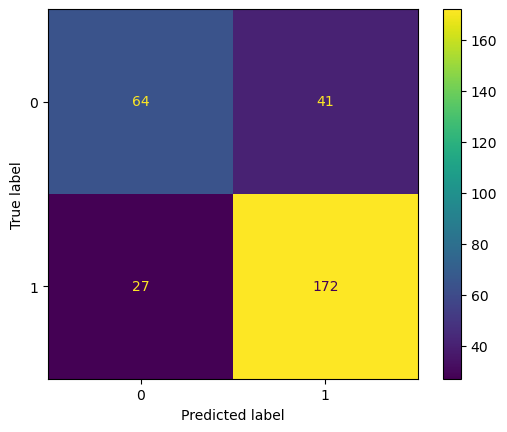

In [23]:
# creating a new instance of logistic regression with optimal parameter C
logreg_optimal = LogisticRegression(max_iter = 10000, C=optimal_params[0], penalty = 'l2')

# fitting optimal logistic regression
logreg_optimal.fit(X_train, y_train) 

# predicting results on the test set
log_pred = logreg_optimal.predict(X_test)

# displaying results of 
confusion_matrix_display(y_test, log_pred)

**Analysis:** Compared to logistic regression with gradient descent, the scikit learn logistic regression preformed better. However, this version of logistic regression was not able to make a significant reduction in false positives. 

**Linear SVM**

The maximum mean test score = 0.746
The optimal value for parameter 'param_C' = 0.3


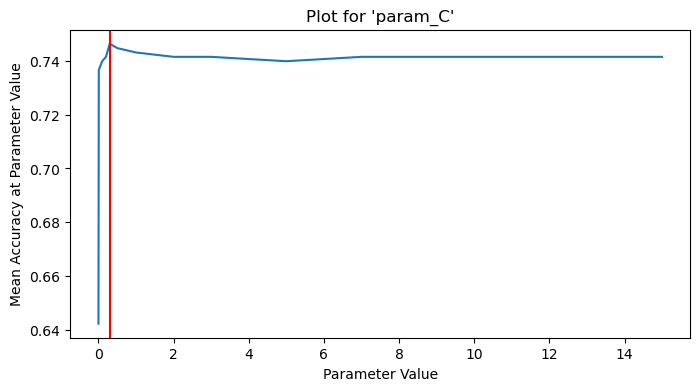

In [24]:
"""
Finding optimal model parameters using grid search and cross-validation. 
"""
# instantiate an instance of a SVM with linear kernel 
linear_svm = SVC(kernel='linear', random_state=1)

# Select the parameters to optimize
parameters_lin_svm = dict((k, parameters[k]) for k in ('C')) # Only C for linear SVM

# perform the grid search for SVM with linear kernel
grid_results_lin_svm = grid_search(linear_svm, parameters_lin_svm, X_train, y_train)

# plot the results 
plots = ["param_C"]
optimal_params = plot_params(grid_results_lin_svm, plots)

The optimal shrinkage parameter, C, for the linear SVM is C = 0.3.

The accuracy of the model is: 75.66 %


<Figure size 1500x1000 with 0 Axes>

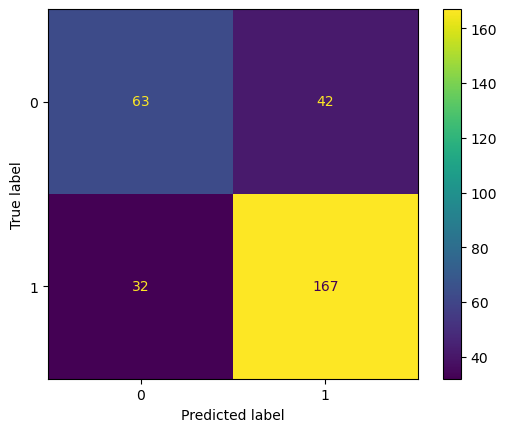

In [25]:
# creating a new instance of logistic regression with optimal parameter C
lin_svm_optimal = SVC(kernel='linear', random_state=1, C=optimal_params[0])

# fitting optimal logistic regression
lin_svm_optimal.fit(X_train, y_train) 

# predicting results on the test set
lin_svm_pred = lin_svm_optimal.predict(X_test)

# displaying results of linear svm
confusion_matrix_display(y_test, lin_svm_pred)

**Analysis** The Linear SVM performed very similarly to the previous logistic regression. This is not suprising since the logistic regression optimization problem is very similar to the linear SVM optimization problem. 

**Non-Linear SVM: Polynomial Kernel**

The maximum mean test score = 0.753
The optimal value for parameter 'param_C' = 2
The optimal value for parameter 'param_degree' = 3


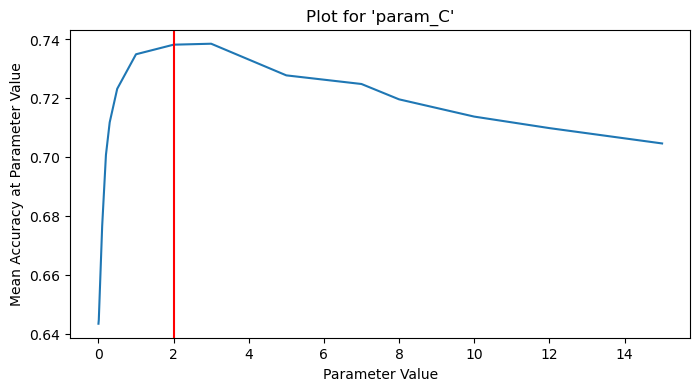

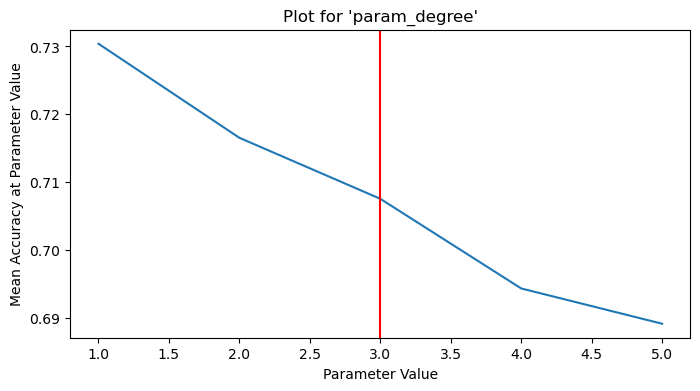

In [26]:
"""
Finding optimal model parameters using grid search and cross-validation. 
"""
# instantiate an instance of a SVM with polynomial kernel 
poly_svm = SVC(kernel='poly', random_state=1)

# Select the parameters to optimize
parameters_poly_svm = dict((k, parameters[k]) for k in ('C', 'degree'))

# perform the grid search for SVM with polynomial kernel
grid_results_poly_svm = grid_search(poly_svm, parameters_poly_svm, X_train, y_train)

# plot the results 
plots = ["param_C", "param_degree"]
optimal_params = plot_params(grid_results_poly_svm, plots)

The SVM with polynomial kernel has 2 parameters which must be optimized: the shrinkage parameter, C and the degree parameter, d. The optimal values are found to be C = 2 and d = 3. 

The accuracy of the model is: 77.30 %


<Figure size 1500x1000 with 0 Axes>

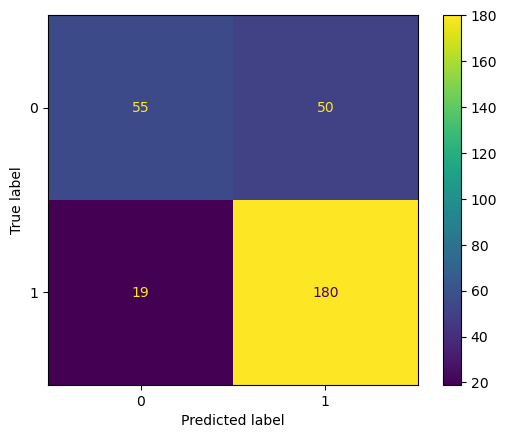

In [27]:
# creating a new instance of SVM with polynomial kernel with optimal parameters C, gamma, and degree
poly_svm_optimal = SVC(kernel='poly', random_state=1, C=optimal_params[0], degree=optimal_params[1])

# fitting optimal poly kernel SVM regression
poly_svm_optimal.fit(X_train, y_train) 

# predicting results on the test set
poly_svm_optimal_pred = poly_svm_optimal.predict(X_test)

# displaying results of 
confusion_matrix_display(y_test, poly_svm_optimal_pred)

**Analysis:** The SVM with the polynomial kernel has similar accuracy to the previous models, but has more false positives, which is not ideal for investors. 

**Non-Linear SVM: Radial Kernel**

The maximum mean test score = 0.766
The optimal value for parameter 'param_C' = 1
The optimal value for parameter 'param_gamma' = 0.1


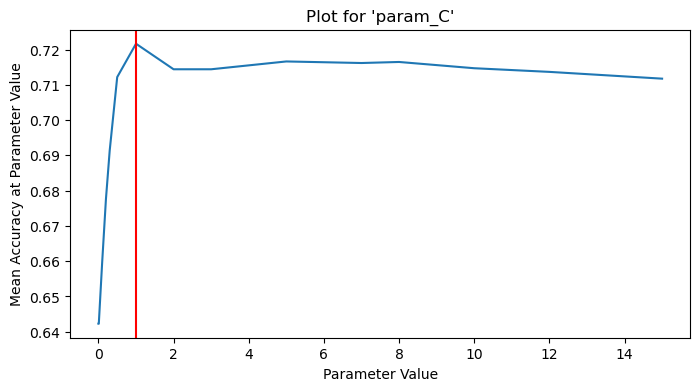

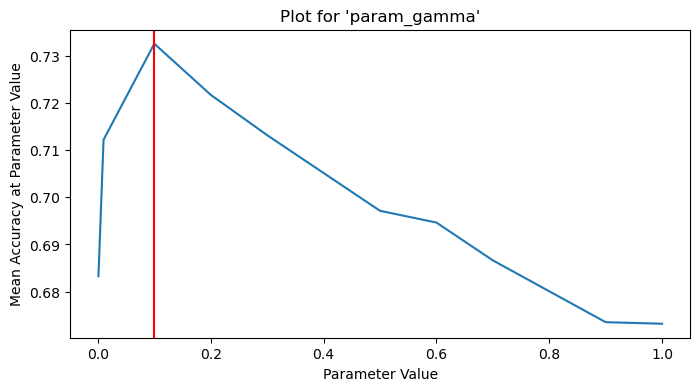

In [28]:
"""
Finding optimal model parameters using grid search and cross-validation. 
"""
# instantiate an instance of a SVM with rbf kernel 
rbf_svm = SVC(kernel='rbf', random_state=1)

# Select the parameters to optimize
parameters_rbf_svm = dict((k, parameters[k]) for k in ('C', 'gamma'))

# perform the grid search for SVM with rbf kernel
grid_results_rbf_svm = grid_search(rbf_svm, parameters_rbf_svm, X_train, y_train)

# plot the results 
plots = ["param_C", "param_gamma"]
optimal_params = plot_params(grid_results_rbf_svm, plots)

The SVM with radial kernel has 2 parameters that must be optimized, C and gamma. the optimal values chosen through cross-validation are C = 1 and gamma = 0.1. 

The accuracy of the model is: 77.96 %


<Figure size 1500x1000 with 0 Axes>

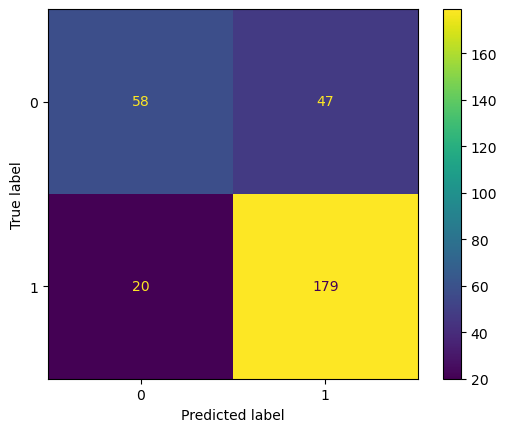

In [29]:
# creating a new instance of SVM with poly kernel with optimal parameters C and gamma
rbf_svm_optimal = SVC(kernel='rbf', random_state=1, C=optimal_params[0], gamma = optimal_params[1])

# fitting optimal poly kernel SVM regression
rbf_svm_optimal.fit(X_train, y_train) 

# predicting results on the test set
rbf_svm_optimal_pred = rbf_svm_optimal.predict(X_test)

# displaying results of 
confusion_matrix_display(y_test, rbf_svm_optimal_pred)

**Analysis:** The SVM with the radial kernel has similar accuracy to the previous models, but has a lot of false positives. This model has slightly higher accuracy than some of the others. 

**Non-Linear SVM: Sigmoid Kernel** 

The maximum mean test score = 0.748
The optimal value for parameter 'param_C' = 12
The optimal value for parameter 'param_gamma' = 0.001


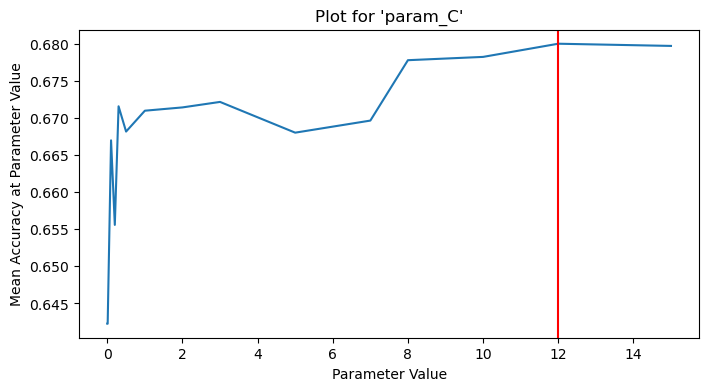

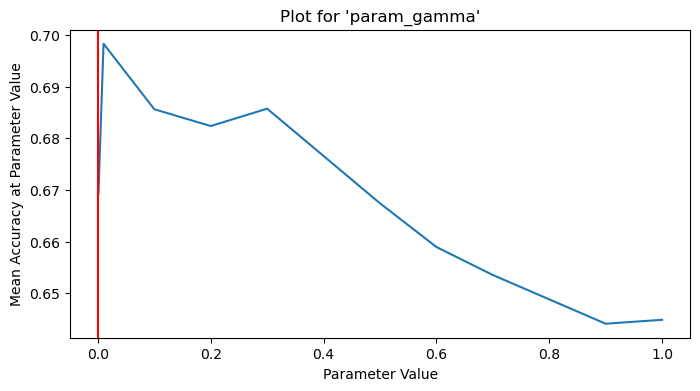

In [30]:
"""
Finding optimal model parameters using grid search and cross-validation. 
"""
# instantiate an instance of a SVM with sigmoid kernel 
sig_svm = SVC(kernel='sigmoid', random_state=1)

# Select the parameters to optimize
parameters_sig_svm = dict((k, parameters[k]) for k in ('C', 'gamma'))

# perform the grid search for SVM with sigmoid kernel
grid_results_sig_svm = grid_search(sig_svm, parameters_sig_svm, X_train, y_train)

# plot the results 
plots = ["param_C", "param_gamma"]
optimal_params = plot_params(grid_results_sig_svm, plots)

The SVM with sigmoid kernel has 2 parameters that must be optimized, C and gamma. The optimal values have been found to be C = 12 and gamma = 0.001. 

The accuracy of the model is: 76.64 %


<Figure size 1500x1000 with 0 Axes>

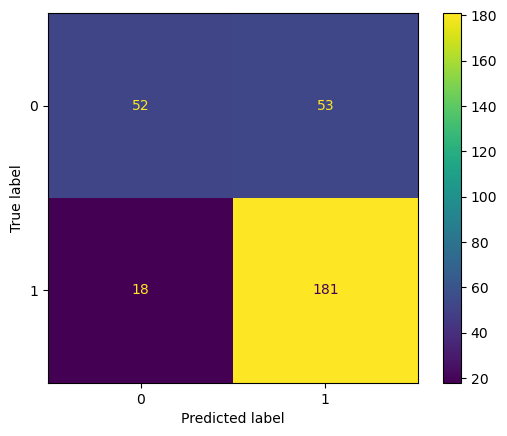

In [31]:
# creating a new instance of SVM with sigmoid kernel with optimal parameters C and gamma
sig_svm_optimal = SVC(kernel='sigmoid', random_state=1, C=optimal_params[0], gamma = optimal_params[1])

# fitting optimal sigmoid kernel SVM regression
sig_svm_optimal.fit(X_train, y_train) 

# predicting results on the test set
sig_svm_optimal_pred = sig_svm_optimal.predict(X_test)

# displaying results of 
confusion_matrix_display(y_test, sig_svm_optimal_pred)

**Analysis:** The SVM with the sigmoid kernel has similar accuracy to the previous models, but has a lot of false positives.

**Neural Network: 1 Layer**

In [32]:
# Change type to numpy array
X_train_np = X_train.to_numpy()
y_train_np  = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np  = y_test.to_numpy()

In [33]:
# Standardize Predictors 
X_train_norm = (X_train_np - np.mean(X_train_np)) / np.std(X_train_np)
X_train_norm = torch.from_numpy(X_train_norm).float()

X_test_norm = (X_test_np - np.mean(X_train_np)) / np.std(X_train_np)
X_test_norm = torch.from_numpy(X_test_norm).float()

y_train_tensor = torch.from_numpy(y_train_np) 
y_test_tensor = torch.from_numpy(y_test_np) 

train_ds = TensorDataset(X_train_norm, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

In [34]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__() # initialize the super class
        self.layer1 = nn.Linear(input_size, output_size)   

    def forward(self, x):
        x = self.layer1(x)  #W^1*x+b^1
        x = nn.Softmax(dim=1)(x) #supports multiclass classification
        return x

In [35]:
# Set model parameters
torch.manual_seed(1)
input_size = X_train_norm.shape[1]
output_size = 2
learning_rate = 0.001

In [36]:
# Initialize model
model = Model(input_size, output_size)

loss_fn = nn.CrossEntropyLoss() #BCE Loss function 
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
num_epochs = 200
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
loss_hist_test = [0] * num_epochs
accuracy_hist_test = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0) 
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.mean()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    
    pred_test = model(X_test_norm) # predict values with current weights on test set
    loss_test = loss_fn(pred_test, y_test_tensor) # calculate test MSE for epoch
    loss_hist_test[epoch] = loss_test.item()  # record test loss for epoch 
    is_correct_test = (torch.argmax(pred_test, dim=1) == y_test_tensor).float()
    accuracy_hist_test[epoch] += is_correct_test.mean()

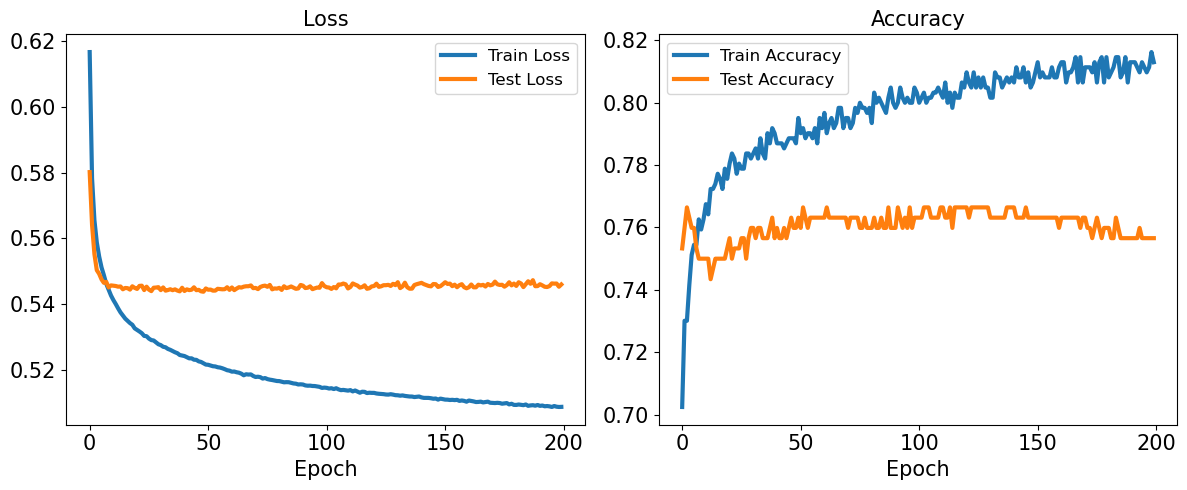

In [38]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.plot(loss_hist_test, lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Train Loss', 'Test Loss'], fontsize=12)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.plot(accuracy_hist_test, lw=3)
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.legend(['Train Accuracy', 'Test Accuracy'], fontsize=12)

 
plt.show()

The accuracy of the model is: 71.38 %


<Figure size 1500x1000 with 0 Axes>

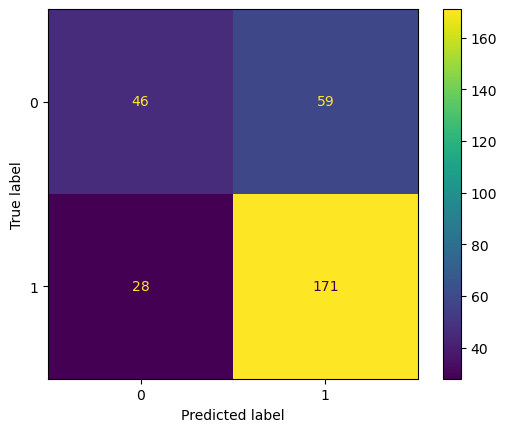

In [39]:
confusion_matrix_display(y_test, is_correct_test)

**Analysis:** It was difficult to build a neural network that did not overfit the data. We can see that the model overfit because the training loss continues to decrease while the testing loss remains constant. This is similar with accuracy where accuracy for the train set is increasing while the accuracy of the test set is remaining constant. Like the other models, the neural network (1 layer) produced a lot of false positives. Since a one layer neural network overfit, it seems likely that a multi-layer neural network will also overfit, but we can try that next. 

**Neural Network: Multi-layer**

In [40]:
hidden_size = 3

In [41]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__() # initialize the super class
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)  #W^1*x+b^1
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x) #supports multiclass classification
        return x

In [42]:
# Initialize model
model = Model(input_size, hidden_size, output_size)

loss_fn = nn.CrossEntropyLoss() #BCE Loss function 
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
num_epochs = 200
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
loss_hist_test = [0] * num_epochs
accuracy_hist_test = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0) 
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.mean()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    
    pred_test = model(X_test_norm) # predict values with current weights on test set
    loss_test = loss_fn(pred_test, y_test_tensor) # calculate test BCE for epoch
    loss_hist_test[epoch] = loss_test.item()  # record test loss for epoch 
    is_correct_test = (torch.argmax(pred_test, dim=1) == y_test_tensor).float()
    accuracy_hist_test[epoch] += is_correct_test.mean()

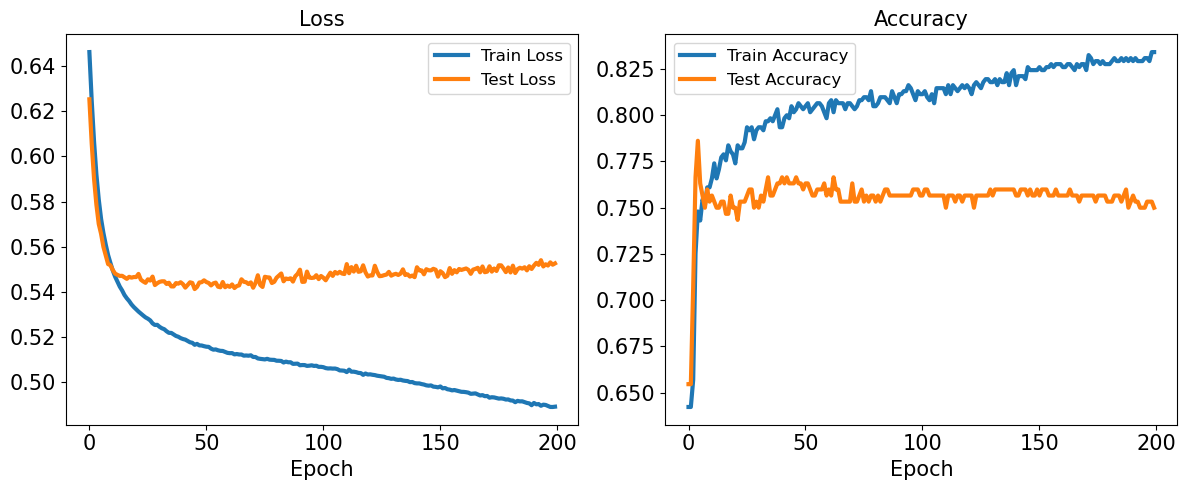

In [44]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.plot(loss_hist_test, lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Train Loss', 'Test Loss'], fontsize=12)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.plot(accuracy_hist_test, lw=3)
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.legend(['Train Accuracy', 'Test Accuracy'], fontsize=12)

plt.show()

The accuracy of the model is: 70.72 %


<Figure size 1500x1000 with 0 Axes>

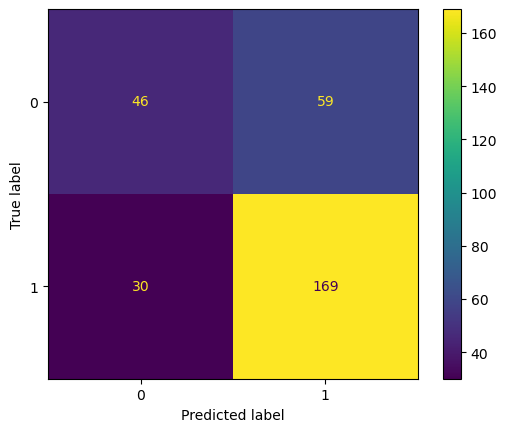

In [45]:
confusion_matrix_display(y_test, is_correct_test)

**Analysis:** Surprisingly, this model seems less overfit than the single layer neural network, but the accuracy did not improve much.

### Summary of Results and Conclusion

| Model     | Accuracy |
| ----------- | ----------- |
| Logistic Regression GD    | 74.67 %       |
| Logistic Regression Scikit Learn  | 77.63 %       |
| Linear SVM  | 75.66 %      |
| Non-Linear SVM Polynomial Kernel  | 77.30 %        |
| Non-Linear SVM Radial Kernel  | 77.96 %       |
| Non-Linear SVM Sigmoid Kernel  | 76.64 %        |
| Neural Network Single Layer  | 71.38 %     |
| Neural Network Multi-Layer  | 71.71%      |


Overall, most of the models had similar performance. The Neural Networks did perform a little worse than the other classification model, and this seems to likely be due to overfitting. The model with the higest accuracy was the Non-Linear SVM with the radial kernel. Any of the models would likely be a good choice for stakeholders, however, we would **recommend using the Logistic Regression** created with Scikit learn. We believe that this model is safer for investors and entrepreneurs because for a marginal reduction in accuracy, there is a 12% decrease in false positive results. As previously discussed, false positive results could lead investors to invest in businesses that are going to fail or for entrepreneurs to start a business that is not likely to be successful. Additionally, the logistic regression model is more interpretable than the SVM models, so this could provide additional useful information to the stakeholders. 

# Appendix

### Video Presentation Link

https://youtu.be/FgQHeEVLrfI

### GitHub Repository

https://github.com/adelynarens/ISE-6194-Final-Project

### Task Distribution

**Amr:** Did the majority of the work on the regression ML problem. Additionally, contributed 50% to the final report and the video presentation. 

**Adelyn:** Did the majority of the work on the classification ML problem and helped as needed on the regression ML problem. Additionally, contributed 50% to the final report and the video presentation. 

### Sources 

1. https://www.mordorintelligence.com/industry-reports/united-states-used-car-market#:~:text=US%20Used%20Car%20Market%20Analysis,disruption%20in%20the%20automotive%20industry.
2. https://www.statista.com/statistics/277501/venture-capital-amount-invested-in-the-united-states-since-1995/#:~:text=Value%20of%20venture%20capital%20investment%20in%20the%20U.S.%202006%2D2022&text=2021%20set%20a%20new%20record,much%20as%20the%20previous%20year.
3. https://www.kaggle.com/datasets/manishkc06/startup-success-prediction
4. https://www.kaggle.com/datasets/thedevastator/uncovering-factors-that-affect-used-car-prices